In [1]:
# Load required libraries

# Load required libraries

import pandas as pd
import numpy as np
import sklearn as sk
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

import re
import random

from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


from imblearn.under_sampling import RandomUnderSampler


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertModel, AdamW
from transformers import AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.nn import Dropout
from torch.nn import Linear
from tqdm import tqdm
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.decomposition import PCA
import torch.nn.functional as F
from transformers import DistilBertConfig
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold



from sklearn.metrics.pairwise import cosine_similarity

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [94]:
import pandas as pd
import pandas as pd
from sklearn.utils import resample
df_1 = pd.read_csv('/kaggle/input/filtered-unequal-data/equal_sample_english_songs_filtered.csv')

In [95]:
# Filtring out lyrics with less than 2000 views and a wordcount less than 150

import pandas as pd

df_cleanup=df_1.copy()
df_cleanup['word_count'] = df_cleanup['lyrics'].str.split().str.len()
df_cleanup = df_cleanup[(df_cleanup['views'] >= 2000) & (df_cleanup["word_count"] >= 150)]

df_cleanup["tag"].value_counts()

tag
rap        19867
pop        14774
rock       10991
rb          3509
country     1360
Name: count, dtype: int64

## Prepare Data for two Step Classification

In [96]:
# Filter the original dataset for only pop and rock songs
df_pop_rock = df_cleanup[df_cleanup['tag'].isin(['pop', 'rock'])]

# Modify labels to group pop and rock
df_cleanup['tag'] = df_cleanup['tag'].replace(['pop', 'rock'], 'pop_rock')


In [97]:
# Sample equal samples for the POP Rock Modell

n_samples_per_group =  5000 # The count of the smallest group

# Perform stratified sampling
df_pop_rock = df_pop_rock.groupby('tag', group_keys=False).apply(lambda x: x.sample(n=n_samples_per_group, random_state=42))

df_pop_rock['tag'].value_counts()

tag
pop     5000
rock    5000
Name: count, dtype: int64

In [98]:
# Sample equal samples for the General Modell

n_samples_per_group =  1300 # The count of the smallest group

# Perform stratified sampling
stratified_sample = df_cleanup.groupby('tag', group_keys=False).apply(lambda x: x.sample(n=n_samples_per_group, random_state=42))

# Print the tag counts
stratified_sample['tag'].value_counts()


tag
country     1300
pop_rock    1300
rap         1300
rb          1300
Name: count, dtype: int64

In [99]:
# Dictionary with tags as keys and the number of additional samples as values
tags_and_samples = {
    'pop_rock': 6000,
    'rap': 2000,
    'rb': 1000,
    'country': 0
}

for target_tag, additional_samples_count in tags_and_samples.items():
    # Filter the original DataFrame for the target tag
    original_tag_df = df_cleanup[df_cleanup['tag'] == target_tag]

    # Identify the IDs in the stratified sample
    stratified_sample_ids = stratified_sample['id'].unique()

    # Remove any rows from the original_tag_df that are already in the stratified sample
    remaining_original_tag_df = original_tag_df[~original_tag_df['id'].isin(stratified_sample_ids)]

    if len(remaining_original_tag_df) >= additional_samples_count:
        # Sample additional rows
        additional_samples = remaining_original_tag_df.sample(n=additional_samples_count, random_state=42)
        # Concatenate the new samples with the stratified sample DataFrame
        stratified_sample = pd.concat([stratified_sample, additional_samples], ignore_index=True)
    else:
        print(f"Not enough unique samples available to add {additional_samples_count} more '{target_tag}' samples.")

# Copying the final DataFrame
df = stratified_sample.copy()

# Display the count of each tag
print(df['tag'].value_counts())


tag
pop_rock    7300
rap         3300
rb          2300
country     1300
Name: count, dtype: int64


In [89]:
df['tag'].value_counts()

tag
pop_rock    9300
rap         3300
rb          3300
country     1300
Name: count, dtype: int64

In [100]:
# If necessary sample the modified data to have a more efficient model

"""
df = resample(df, n_samples=7000, random_state=42, replace=False)

df["tag"].value_counts()"""

'\ndf = resample(df, n_samples=7000, random_state=42, replace=False)\n\ndf["tag"].value_counts()'

In [101]:
# When necessary to clean the lyrics from unnecessary signs etc.

"""# Function to clean text
def clean_text(text):
    # Remove the text in brackets
    text = re.sub(r'\[.*?\]', '', text)
    # Replace line breaks and multiple whitespaces with a single space
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    # Strip leading and trailing whitespaces
    text = text.strip()
    return text

# Apply the cleaning function to your text column
df['lyrics'] = df['lyrics'].apply(clean_text)

print(df['lyrics'])"""

"# Function to clean text\ndef clean_text(text):\n    # Remove the text in brackets\n    text = re.sub(r'\\[.*?\\]', '', text)\n    # Replace line breaks and multiple whitespaces with a single space\n    text = re.sub(r'\n+', ' ', text)\n    text = re.sub(r'\\s+', ' ', text)\n    # Strip leading and trailing whitespaces\n    text = text.strip()\n    return text\n\n# Apply the cleaning function to your text column\ndf['lyrics'] = df['lyrics'].apply(clean_text)\n\nprint(df['lyrics'])"

## New Preparation

In [102]:
# Mapping labels to numbers
label_mapping = {"pop_rock": 0, 'rb': 1, "country": 2, "rap": 3}

df['numeric_labels'] = df['tag'].map(label_mapping)

# Train/Test Split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['numeric_labels'])

# Convert train and test data to lists
train_lyrics = train_df['lyrics'].tolist()
train_labels = torch.tensor(train_df['numeric_labels'].tolist())

test_lyrics = test_df['lyrics'].tolist()
test_labels = torch.tensor(test_df['numeric_labels'].tolist())

# Tokenizer and Model
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

###############################################################################################################


In [103]:

# Pop Rock Modell

# Mapping labels to numbers
label_mapping_pr = {"pop": 0, 'rock': 1}

df_pop_rock['numeric_labels'] = df_pop_rock['tag'].map(label_mapping_pr)

# Train/Test Split
train_df_pr, test_df_pr = train_test_split(df_pop_rock, test_size=0.2, random_state=42, stratify=df_pop_rock['numeric_labels'])

# Convert train and test data to lists
train_lyrics_pr = train_df_pr['lyrics'].tolist()
train_labels_pr = torch.tensor(train_df_pr['numeric_labels'].tolist())

test_lyrics_pr = test_df_pr['lyrics'].tolist()
test_labels_pr = torch.tensor(test_df_pr['numeric_labels'].tolist())


In [104]:
class SongsDataset(Dataset):
    def __init__(self, songs, labels, tokenizer):
        self.songs = songs
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.songs)

    def __getitem__(self, idx):
        song = str(self.songs[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            song,
            truncation=True,
            padding='max_length',
            max_length=512,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [105]:
# Create datasets
train_dataset = SongsDataset(train_lyrics, train_labels, tokenizer)
test_dataset = SongsDataset(test_lyrics, test_labels, tokenizer)

# Data loaders
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


###################################################################################


In [106]:
# Create datasets
train_dataset_pr = SongsDataset(train_lyrics_pr, train_labels_pr, tokenizer)
test_dataset_pr = SongsDataset(test_lyrics_pr, test_labels_pr, tokenizer)

# Data loaders
batch_size = 16
train_dataloader_pr = DataLoader(train_dataset_pr, batch_size=batch_size, shuffle=True)
test_dataloader_pr = DataLoader(test_dataset_pr, batch_size=batch_size, shuffle=False)

# Modell Training

In [108]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 6
warmup_steps = 200

# Normal Modell

Starting Training


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/6


  0%|          | 0/710 [00:00<?, ?it/s]/tmp/ipykernel_26/257860738.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.long)
100%|██████████| 710/710 [07:30<00:00,  1.58it/s]


Train Loss: 0.8080560486921122
Epoch 2/6


100%|██████████| 710/710 [07:32<00:00,  1.57it/s]


Train Loss: 0.5834314277054559
Epoch 3/6


100%|██████████| 710/710 [07:32<00:00,  1.57it/s]


Train Loss: 0.5035822107863258
Epoch 4/6


100%|██████████| 710/710 [07:33<00:00,  1.57it/s]


Train Loss: 0.4244012938786141
Epoch 5/6


100%|██████████| 710/710 [07:33<00:00,  1.57it/s]


Train Loss: 0.3584011220123986
Epoch 6/6


100%|██████████| 710/710 [07:32<00:00,  1.57it/s]


Train Loss: 0.3137725191269542


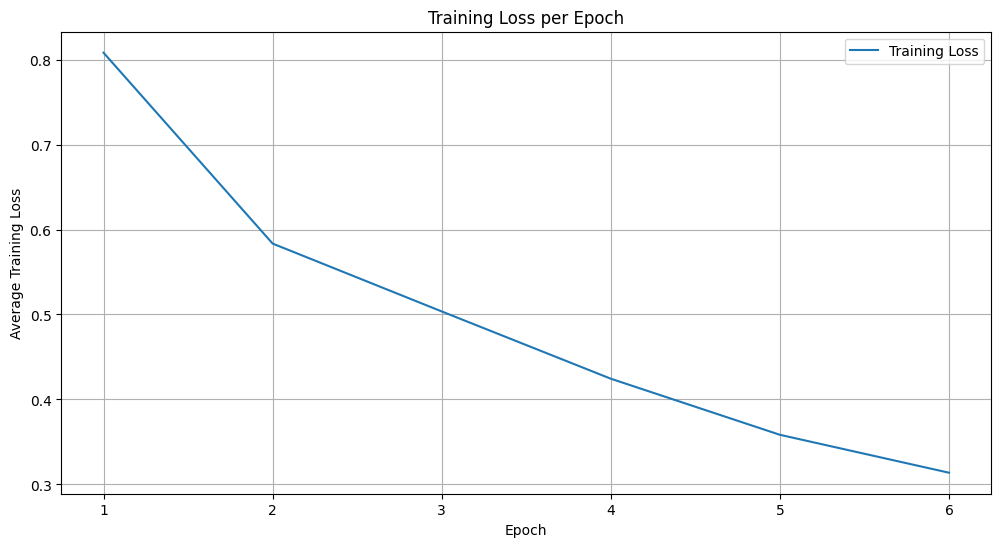

In [109]:
import matplotlib.pyplot as plt

# Assuming num_epochs is defined
# Initialize a list to hold the average training loss for each epoch
train_loss_per_epoch = []

# Training loop
print("Starting Training")
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping))
model.to(device)
model.train()

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)  # Add weight_decay for L2 regularization
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    total_train_loss = 0

    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = nn.CrossEntropyLoss()(logits, labels)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    # Calculate average loss for this epoch and append to the list
    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Train Loss: {avg_train_loss}")
    train_loss_per_epoch.append(avg_train_loss)

# Plotting the training loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_loss_per_epoch, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.legend()
plt.grid(True)
plt.show()


# Evaluation

/tmp/ipykernel_26/257860738.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.long)


Accuracy: 0.768661971830986
F1 Score: 0.7645719409156209


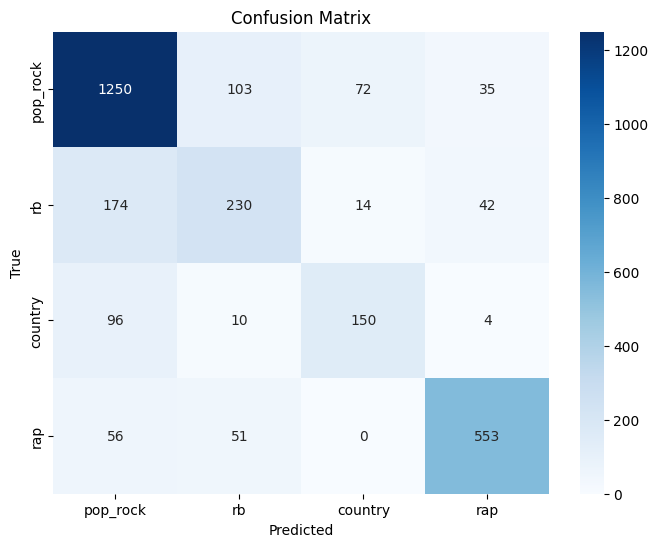

Classification Report:
              precision    recall  f1-score   support

    pop_rock       0.79      0.86      0.82      1460
          rb       0.58      0.50      0.54       460
     country       0.64      0.58      0.60       260
         rap       0.87      0.84      0.85       660

    accuracy                           0.77      2840
   macro avg       0.72      0.69      0.71      2840
weighted avg       0.76      0.77      0.76      2840



In [110]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns



# Prepare the model for evaluation
model.eval()
predictions = []
true_labels = []

# Disable gradient calculations
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.extend(np.argmax(logits, axis=1))
        true_labels.extend(label_ids)

# Calculate accuracy and F1 score
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

# Generate and visualize the confusion matrix
cm = confusion_matrix(true_labels, predictions)
label_names = list(label_mapping.keys())  # Replace with your label names if different
cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=label_names))


# Pop Rock Modell

In [111]:
# Assuming num_epochs, model_name, device, warmup_steps, label_mapping_pr, train_dataloader_pr, test_dataloader_pr are defined
# Initialize a list to hold the average training loss for each epoch
train_loss_per_epoch = []

num_epochs= 7
# Training loop
print("Starting Training")
model_pr = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping_pr))
model_pr.to(device)
model_pr.train()

optimizer = AdamW(model_pr.parameters(), lr=1e-5, weight_decay=0.001)  # Add weight_decay for L2 regularization
total_steps = len(train_dataloader_pr) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    total_train_loss = 0

    for batch in tqdm(train_dataloader_pr):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model_pr(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = nn.CrossEntropyLoss()(logits, labels)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_pr.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    # Calculate average loss for this epoch and append to the list
    avg_train_loss = total_train_loss / len(train_dataloader_pr)
    print(f"Train Loss: {avg_train_loss}")
    train_loss_per_epoch.append(avg_train_loss)

# Plotting the training loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_loss_per_epoch, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.legend()
plt.grid(True)
plt.show()


Starting Training


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/7


  0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_26/257860738.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.long)
100%|██████████| 500/500 [04:59<00:00,  1.67it/s]


Train Loss: 0.6141248126626014
Epoch 2/7


100%|██████████| 500/500 [04:58<00:00,  1.67it/s]


Train Loss: 0.5258871616721154
Epoch 3/7


100%|██████████| 500/500 [04:59<00:00,  1.67it/s]


Train Loss: 0.4507371516823769
Epoch 4/7


100%|██████████| 500/500 [04:59<00:00,  1.67it/s]


Train Loss: 0.36602830988168716
Epoch 5/7


100%|██████████| 500/500 [04:59<00:00,  1.67it/s]


Train Loss: 0.29531413301080467
Epoch 6/7


  2%|▏         | 12/500 [00:07<04:54,  1.66it/s]


KeyboardInterrupt: 

# Evaluation Pop Rock Modell

/tmp/ipykernel_26/257860738.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.long)


Accuracy: 0.7115
F1 Score: 0.7114393301191576


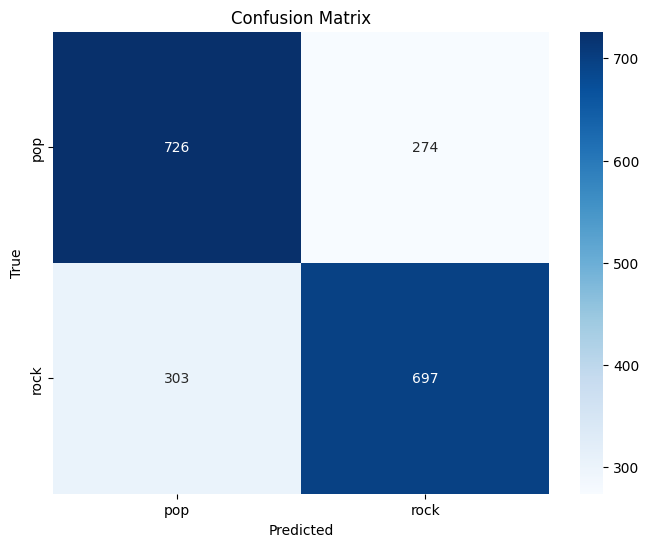

Classification Report:
              precision    recall  f1-score   support

         pop       0.71      0.73      0.72      1000
        rock       0.72      0.70      0.71      1000

    accuracy                           0.71      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.71      0.71      0.71      2000



In [112]:
# Prepare the model for evaluation
model_pr.eval()
predictions = []
true_labels = []

# Disable gradient calculations
with torch.no_grad():
    for batch in test_dataloader_pr:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model_pr(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.extend(np.argmax(logits, axis=1))
        true_labels.extend(label_ids)

# Calculate accuracy and F1 score
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

# Generate and visualize the confusion matrix
cm = confusion_matrix(true_labels, predictions)
label_names_pr = list(label_mapping_pr.keys())  # Replace with your label names if different
cm_df = pd.DataFrame(cm, index=label_names_pr, columns=label_names_pr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=label_names_pr))

# Evaluation of Final Test Data

In [120]:
df_finaltest = pd.read_csv('/kaggle/input/equal-sample/equal_sample_english_songs_50000.csv')


df_finaltest['word_count'] = df_finaltest['lyrics'].str.split().str.len()
df_finaltest = df_finaltest[(df_finaltest['views'] >= 2000) & (df_finaltest["word_count"] >= 150)]

df_finaltest["tag"].value_counts()


tag
rb         1433
rap        1342
rock       1129
country    1009
pop         705
Name: count, dtype: int64

In [114]:

# Sample 10000 random records from the dataset
df_finaltest = resample(df_finaltest, n_samples=3000, random_state=42, replace=False)

# Get the counts of each tag/category
tag_counts = df_finaltest['tag'].value_counts()


In [121]:
label_mapping = {"pop_rock": 0, 'rb': 1, "country": 2, "rap": 3}
label_mapping_pr = {"pop": 0, "rock": 1}  # Assuming this is the mapping for your second model

# Modify true labels for comparison
external_true_labels = df_finaltest['tag'].tolist()
external_true_labels_modified = ['pop_rock' if tag in ['pop', 'rock'] else tag for tag in external_true_labels]

# Convert modified true labels to numeric
external_numeric_labels = torch.tensor([label_mapping[label] for label in external_true_labels_modified])


In [122]:
model.eval()
first_step_predictions = []

with torch.no_grad():
    for batch in external_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        first_step_predictions.extend(preds.cpu().numpy())


/tmp/ipykernel_26/257860738.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.long)


In [123]:
model_pr.eval()
final_predictions = first_step_predictions.copy()

for i, pred in enumerate(first_step_predictions):
    if pred == label_mapping['pop_rock']:
        input_id = external_dataset[i]['input_ids'].unsqueeze(0).to(device)
        attention = external_dataset[i]['attention_mask'].unsqueeze(0).to(device)

        with torch.no_grad():
            output_2 = model_pr(input_id, attention)
            logits_2 = output_2.logits
            refined_pred = torch.argmax(logits_2, dim=1).cpu().numpy()[0]

        # Update the prediction from 'pop_rock' to 'pop' or 'rock'
        final_predictions[i] = refined_pred + len(label_mapping)  # Adjust index for 'pop' and 'rock'


/tmp/ipykernel_26/257860738.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.long)


In [124]:
# Reverse the label mapping to match numeric predictions with original labels
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
reverse_label_mapping.update({len(label_mapping) + v: k for k, v in label_mapping_pr.items()})

# Convert numeric predictions back to label names
final_predictions_labels = [reverse_label_mapping[pred] for pred in final_predictions]

# Calculate accuracy
overall_accuracy = accuracy_score(external_true_labels, final_predictions_labels)
print(f"Overall Accuracy: {overall_accuracy}")


Overall Accuracy: 0.6525453898184407


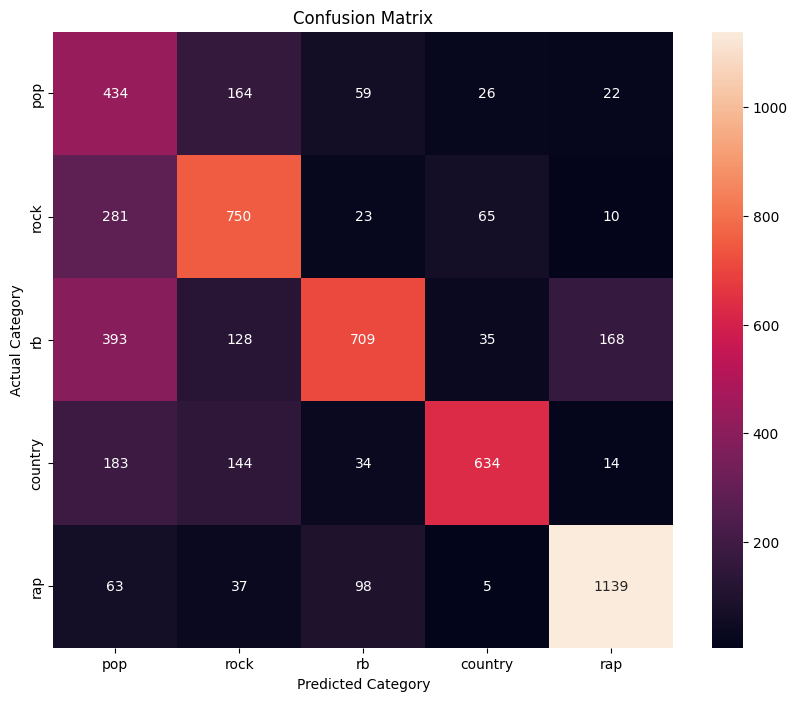

In [125]:
# Generate the confusion matrix

# Reverse the label mapping to include only final categories
reverse_label_mapping_final = {0: 'pop', 1: 'rock', 2: 'rb', 3: 'country', 4: 'rap'}

cm = confusion_matrix(external_true_labels, final_predictions_labels, labels=list(reverse_label_mapping_final.values()))

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=reverse_label_mapping_final.values(), yticklabels=reverse_label_mapping_final.values())
plt.title("Confusion Matrix")
plt.ylabel("Actual Category")
plt.xlabel("Predicted Category")
plt.show()


In [126]:
torch.save(model, 'model_complete.pth')
torch.save(model_pr, 'model_pr.pth')

